# PLOTS FOR ENERGY EFFICIENCY

In [67]:
import matplotlib.pyplot as plt
import numpy as np 
import cmath
import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d

from Functions import *

In [68]:
#============== System parameters
'''
Defining Parameters
    Nt = Number of transmit antennas (SISO = 1)
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

'''
Nt = 1
K = 10
# gamma = db2pow(20)
nIRSrow = 10
nIRScol = nIRSrow
Ns = nIRSrow*nIRScol
f = 2.4e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
BW = 20e6
NF = 10
noise = -174+10*np.log10(BW) + NF

# Network Parameters
BASE_STATION_POSITION = (0, 0, 20)
TRANSMIT_POWER_WATTS = 4 #in watts
NUM_SIMULATIONS = 100

# Fading Paramters
FADING_STD_MEAN = 0
FADING_STD_DEV = 3
m = 1 #Changed the shape from 1 to 2
omega = np.sqrt(0.5)

# Path Loss Parameters
BETA1 = 2.8 #path loss exponent (indirect) bs -> irs
BETA2 = 2.2  #path loss exponent (indirect) irs -> user
ALPHA = 3.8 #path loss exponent (direct) bs -> user

# Power consumption params
wn = 0.5
Pb = 10 # in dBw
Pu = 10 # 10 in dBm

#Practical phase shift model paramters
a = 1.6
phi = 0.43 * np.pi
B_min = 0.2

# Generate BS position
xt, yt, zt = BASE_STATION_POSITION
loc_T = np.array([BASE_STATION_POSITION])

In [69]:
grid_radius_array = np.arange(0,2401,200)

# Define empty lists
grid_area_list = []
IRS_POSITION_1_list = []
IRS_POSITION_2_list = []
loc_U_list = []
threshold_list = []
dTU_list = []
dTS_1_list = []
dTS_2_list = []
dSU_1_list = []
dSU_2_list = []

# Usage within the loop
for GRID_RADIUS in grid_radius_array:
    
    # Function calculate_values_for_radius returns the following 4 quantities
    grid_area, IRS_POSITION_1, IRS_POSITION_2, loc_U , threshold= calculate_values_for_radius(GRID_RADIUS, K) 

    # Append the values to the respective lists
    grid_area_list.append(grid_area)
    IRS_POSITION_1_list.append(IRS_POSITION_1)
    IRS_POSITION_2_list.append(IRS_POSITION_2)
    loc_U_list.append(loc_U)
    threshold_list.append(threshold)

    xs_1, ys_1, zs_1 = IRS_POSITION_1
    loc_S_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)

    xs_2, ys_2, zs_2 = IRS_POSITION_2
    loc_S_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)

    # #Distance Calulation
    dTU_temp, dSU_1_temp, dTS_1_temp = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    dTU_temp, dSU_2_temp, dTS_2_temp = calculate_distances_3D(loc_U, loc_T, loc_S_2)

    dTU_list.append(dTU_temp.transpose()[0])
    dTS_1_list.append(dTS_1_temp.transpose()[0])
    dTS_2_list.append(dTS_2_temp.transpose()[0])
    dSU_1_list.append(dSU_1_temp.transpose()[0])
    dSU_2_list.append(dSU_2_temp.transpose()[0])


grid_area_list = np.array(grid_area_list) # Shape = (len(grid_radius_array),)
IRS_POSITION_1_list = np.array(IRS_POSITION_1_list) # Shape = (len(grid_radius_array), 3)
IRS_POSITION_2_list = np.array(IRS_POSITION_2_list) # Shape = (len(grid_radius_array), 3)
loc_U_list = np.array(loc_U_list) # Shape = (len(grid_radius_array), K, 3)
threshold_list = np.array(threshold_list)

dTU_list = np.array(dTU_list)
dTU_list = np.vstack(dTU_list)  # Shape = (len(grid_radius_array), K)

dTS_1_list = np.array(dTS_1_list)
dTS_1_list = np.vstack(dTS_1_list)  # Shape = (len(grid_radius_array), Ns)

dTS_2_list = np.array(dTS_2_list)
dTS_2_list = np.vstack(dTS_2_list)  # Shape = (len(grid_radius_array), Ns)

dSU_1_list = np.array(dSU_1_list)
dSU_1_list = np.vstack(dSU_1_list)  # Shape = (len(grid_radius_array), K)

dSU_2_list = np.array(dSU_2_list)
dSU_2_list = np.vstack(dSU_2_list)  # Shape = (len(grid_radius_array), K)



# print(IRS_POSITION_1_list.shape)
# print()
# print(IRS_POSITION_2_list.shape)
# print()
print(dTU_list.shape)
# print()
print(threshold_list)
# print(dSU_2_list.shape)


(13, 10)
[  0.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240.]


# Generating channels

In [70]:
h_dk_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),K,1), dtype= np.complex128)
h_rk1_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),Ns,K), dtype= np.complex128)
h_rk1_h_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),K,Ns), dtype= np.complex128)
G1_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),Ns,1), dtype= np.complex128)
h_rk2_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),Ns,K), dtype= np.complex128)
h_rk2_h_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),K,Ns), dtype= np.complex128) 
G2_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),Ns,1), dtype= np.complex128)

# Perform simulations
for i in range(NUM_SIMULATIONS):
        
    for j in range(len(grid_radius_array)):
        # Generate the Rayleigh Fading Channel for each user (h_dk)
        # h_dk = np.zeros((K,1))
        h_dk = np.array(generate_rayleigh_fading_channel(K,FADING_STD_MEAN,FADING_STD_DEV))
        for m in range(K):
            dTU = dTU_list[j]
            dThreshold = threshold_list[j]
            if(dTU[m] > dThreshold*0):
                h_dk[m] = 0
            else:
                h_dk[m] = h_dk[m]
        h_dk = np.reshape(h_dk ,(K,1))
        h_dk_4d[i][j] = h_dk
        
        # Generate the Nakagami Channel from each user to the IRS-1 (h_rk1)
        fading = []
        for user in range(K):
            fading.append(generate_nakagami_samples(m,omega,Ns)) 
        h_rk1 = fading
        h_rk1 = np.reshape(h_rk1,(Ns,K))
        h_rk1_transpose = np.transpose(h_rk1)
        h_rk1_h = np.conj(h_rk1_transpose)
        h_rk1_4d[i][j] = h_rk1
        h_rk1_h_4d[i][j] = h_rk1_h


        # Generate the Nakagami Channel from each user to the IRS-2 (h_rk2)
        fading = []
        for user in range(K):
            fading.append(generate_nakagami_samples(m,omega,Ns)) 
        h_rk2 = fading
        h_rk2 = np.reshape(h_rk2,(Ns,K))
        h_rk2_transpose = np.transpose(h_rk2)
        h_rk2_h = np.conj(h_rk2_transpose)
        h_rk2_4d[i][j] = h_rk2
        h_rk2_h_4d[i][j] = h_rk2_h

        # Generate the Nakagami Channel from base_station to the IRS-1 (G1)
        G1 = generate_nakagami_samples(m,omega,Ns) 
        G1 = np.reshape(G1,(Ns,1))
        G1_4d[i][j] = G1

        # Generate the Nakagami Channel from base_station to the IRS-2 (G2)
        G2 = generate_nakagami_samples(m,omega,Ns)
        G2 = np.reshape(G2,(Ns,1))
        G2_4d[i][j] = G2

print('Size of hdk4d', (h_dk_4d))
print('Size of hrk4d', np.shape(h_rk1_4d))
print('Size of hrkh4d', np.shape(h_rk1_h_4d))
print('Size of g4d', np.shape(G1_4d))

Size of hdk4d [[[[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]

  [[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]

  [[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]

  ...

  [[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]

  [[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]

  [[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]]


 [[[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]

  [[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]

  [[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]

  ...

  [[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]

  [[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]

  [[0.+0.j]
   [0.+0.j]
   [0.+0.j]
   ...
   [0.+0.j]
   [0.+0.j]
   [0.+0.j]]

In [71]:
# h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

# # BS to IRS
# G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
# G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

# # IRS to Users
# h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
# h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)    
# h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)

# DOUBLE IRS CASE (IDEAL, CONTINUOUS)

In [72]:
B = None
RATE_THRESHOLD = 10

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

area_energy_efficiency_1 = []
area_spectral_efficiency_1 = []

for i in range(len(grid_radius_array)):

    grid_area = grid_area_list[i]
    
    # Generate IRS position_1
    # IRS_position_1 = IRS_POSITION_1_list[i]
    # xs_1, ys_1, zs_1 = IRS_POSITION_1

    # irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
    # loc_S_1 = irs_coords_1
    # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
    # print()
    
    # Generate IRS position_2
    # IRS_position_2 = IRS_POSITION_2_list[i]
    # xs_2, ys_2, zs_2 = IRS_POSITION_2

    # irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
    # loc_S_2 = irs_coords_2
    # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
    # print()

    # loc_U = loc_U_list[i]
    
    # dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    # dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
    
    # Reshapiing the distance from antennas/BS to user
    dTU = dTU_list[i]
    # print('dTU',dTU.shape)

    # Compute row-wise averages
    dSU_1 = dSU_1_list[i]
    # dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
    dSU_1 = dSU_1.reshape(1,K)
    # print('dSU1',dSU_1.shape)
    
    # Compute the sum of elements in each row
    dTS_1 = dTS_1_list[i]
    # dTS_1 = np.mean(dTS_1, axis=1)
    # Compute the average of row sums
    dTS_1 = np.mean(dTS_1)
    # print('dTS1',dTS_1.shape)

    # Compute row-wise averages
    dSU_2 = dSU_2_list[i]
    # dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
    dSU_2 = dSU_2.reshape(1,K)
    # print('dSU2',dSU_2.shape)

    # Compute the sum of elements in each row
    dTS_2 = dTS_2_list[i]
    # dTS_2 = np.mean(dTS_2, axis=1)
    # Compute the average of row sums
    dTS_2 = np.mean(dTS_2)
    # print('dTS2',dTS_2.shape)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
    # Direct Link
    h_dk_values = h_dk_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, 1)

    # BS to IRS
    G1_ns_values = G1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)
    G2_ns_values = G2_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)

    # IRS to Users
    h_rk1_ns_values = h_rk1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk2_ns_values = h_rk2_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk1_h_ns_values = h_rk1_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
    h_rk2_h_ns_values = h_rk2_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Initialize list to store area_energy_efficiency
    area_energy_efficiency = []
    
    # Initialize area_spectral_efficiency for this case
    area_spectral_efficiency = []

    # Perform simulations
    for s in range(NUM_SIMULATIONS):
        h_dk = h_dk_values[s] # Shape: (K, 1)
        h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
        h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
        G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

        h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
        h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
        G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
        
        theta_1 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None)
        theta_2 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, quantized_theta_set= None)

        results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
        results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)

    # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
        arr_link_budget = np.zeros((K,1))
        for m in range (K):
            arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* (((h_dk[m])/(np.sqrt((dTU[m])**ALPHA)))+ (results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1)))  + (results_array_2[m]/np.sqrt((dSU_2[:,m]**BETA2)*(dTS_2**BETA1)))))
            arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
            arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
            arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
            outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
        arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

        # Calculate the Area Spectral Efficiency (ASE)
        ASE = arr_sumrate_disc[s]/grid_area
        area_spectral_efficiency.append(ASE)

        # Calculate the total power of the system
        power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
        power_21 = compute_power_consumption_at_ris(B, Ns)
        power_22 = compute_power_consumption_at_ris(B, Ns)
        power_3 = (10**(Pu/10))/1000
        power_3 = power_3 * K
        P = power_1 + power_21 + power_22 + power_3

        # Compute the energy efficiency and the Area Energy Efficiency (AEE)
        ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
        AEE = ASE/P # Using the ASE and total power
        area_energy_efficiency.append(ee/1e6) 

    # Compute the average area energy efficiency
    area_energy_efficiency_1.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
    
    # Append the average ASE for this T to the list
    area_spectral_efficiency_1.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))
    
print('done')
print(area_energy_efficiency_1)

C:\Users\TQUma\AppData\Local\Temp\ipykernel_12796\3360781433.py:120: RuntimeWarning: divide by zero encountered in divide
  ASE = arr_sumrate_disc[s]/grid_area


done
[178.6718831880049, 110.25041062722862, 97.58806381612854, 73.86738987958546, 47.32157023166903, 46.26690394450393, 48.764885700907456, 40.784456219049645, 30.015401218676125, 27.397475815137376, 17.36353502671621, 16.40945357941999, 21.91215571025206]


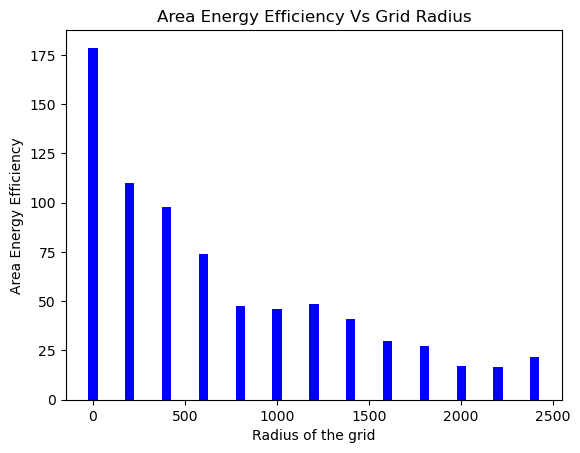

In [73]:
# Create a bar graph
bar_width = 50
plt.bar(grid_radius_array, area_energy_efficiency_1, color='blue', alpha=1, width=bar_width)
plt.ylabel('Area Energy Efficiency')
plt.xlabel('Radius of the grid')
plt.title('Area Energy Efficiency Vs Grid Radius')
plt.show()

# DOUBLE IRS CASE (PRACTICAL, DISCRETE WITH B = 3)

In [74]:
RATE_THRESHOLD = 10
B = 3

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

area_energy_efficiency_2 = []
area_spectral_efficiency_2 = []

for i in range(len(grid_radius_array)):

    grid_area = grid_area_list[i]
    
    # Generate IRS position_1
    # IRS_position_1 = IRS_POSITION_1_list[i]
    # xs_1, ys_1, zs_1 = IRS_POSITION_1

    # irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
    # loc_S_1 = irs_coords_1
    # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
    # print()
    
    # Generate IRS position_2
    # IRS_position_2 = IRS_POSITION_2_list[i]
    # xs_2, ys_2, zs_2 = IRS_POSITION_2

    # irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
    # loc_S_2 = irs_coords_2
    # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
    # print()

    # loc_U = loc_U_list[i]
    
    # dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    # dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
    
    # Reshapiing the distance from antennas/BS to user
    dTU = dTU_list[i]

    # Compute row-wise averages
    dSU_1 = dSU_1_list[i]
    # dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
    dSU_1 = dSU_1.reshape(1,K)

    # Compute the sum of elements in each row
    dTS_1 = dTS_1_list[i]
    # dTS_1 = np.mean(dTS_1, axis=1)
    # Compute the average of row sums
    dTS_1 = np.mean(dTS_1)

    # Compute row-wise averages
    dSU_2 = dSU_2_list[i]
    # dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
    dSU_2 = dSU_2.reshape(1,K)

    # Compute the sum of elements in each row
    dTS_2 = dTS_2_list[i]
    # dTS_2 = np.mean(dTS_2, axis=1)
    # Compute the average of row sums
    dTS_2 = np.mean(dTS_2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
    # Direct Link
    h_dk_values = h_dk_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, 1)

    # BS to IRS
    G1_ns_values = G1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)
    G2_ns_values = G2_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)

    # IRS to Users
    h_rk1_ns_values = h_rk1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk2_ns_values = h_rk2_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk1_h_ns_values = h_rk1_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
    h_rk2_h_ns_values = h_rk2_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Initialize list to store area_energy_efficiency
    area_energy_efficiency = []
    
    # Initialize area_spectral_efficiency for this case
    area_spectral_efficiency = []

    # Perform simulations
    for s in range(NUM_SIMULATIONS):
        h_dk = h_dk_values[s]
        h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
        h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
        G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

        h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
        h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
        G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
        
        theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )
        theta_2 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )

        results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
        results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)

    # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
        arr_link_budget = np.zeros((K,1))
        for m in range (K):
            arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* (((h_dk[m])/(np.sqrt((dTU[m])**ALPHA)))+ (results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1)))  + (results_array_2[m]/np.sqrt((dSU_2[:,m]**BETA2)*(dTS_2**BETA1)))))
            arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
            arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
            arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
            outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
        arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

        # Calculate the Area Spectral Efficiency (ASE)
        ASE = arr_sumrate_disc[s]/grid_area
        area_spectral_efficiency.append(ASE)

        # Calculate the total power of the system
        power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
        power_21 = compute_power_consumption_at_ris(B, Ns)
        power_22 = compute_power_consumption_at_ris(B, Ns)
        power_3 = (10**(Pu/10))/1000
        power_3 = power_3 * K
        P = power_1 + power_21 + power_22 + power_3

        # Compute the energy efficiency and the Area Energy Efficiency (AEE)
        ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
        AEE = ASE/P # Using the ASE and total power
        area_energy_efficiency.append(ee/1e6) 

    # Compute the average area energy efficiency
    area_energy_efficiency_2.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
    
    # Append the average ASE for this T to the list
    area_spectral_efficiency_2.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))
    
print('done')
print(area_energy_efficiency_2)

C:\Users\TQUma\AppData\Local\Temp\ipykernel_12796\2645134610.py:117: RuntimeWarning: divide by zero encountered in divide
  ASE = arr_sumrate_disc[s]/grid_area


done
[294.51388845218656, 176.30978493863532, 153.52600878502466, 112.41207007622634, 66.83335893418446, 65.94869397450009, 68.68525154472792, 55.94568294391355, 38.99605400097079, 34.494961267638, 19.424648077321184, 18.03047514931221, 27.600524943419238]


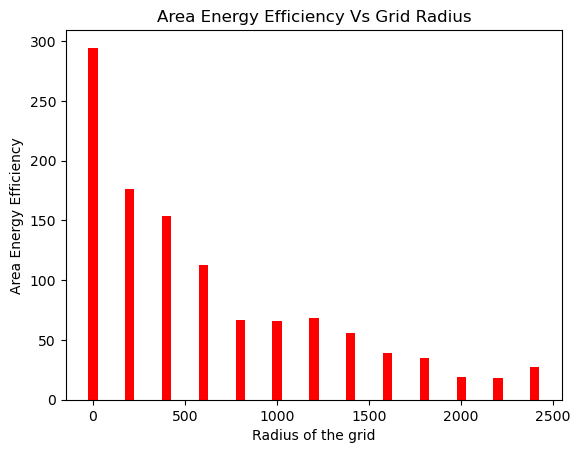

In [75]:
# Create a bar graph
bar_width = 50
plt.bar(grid_radius_array, area_energy_efficiency_2, color='red', alpha=1, width=bar_width)
plt.ylabel('Area Energy Efficiency')
plt.xlabel('Radius of the grid')
plt.title('Area Energy Efficiency Vs Grid Radius')
plt.show()

# SINGLE IRS CASE (IDEAL, CONTINUOUS)

In [76]:
B = None

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

area_energy_efficiency_3 = []
area_spectral_efficiency_3 = []

for i in range(len(grid_radius_array)):

    grid_area = grid_area_list[i]
    
    # Generate IRS position_1
    # IRS_position_1 = IRS_POSITION_1_list[i]
    # xs_1, ys_1, zs_1 = IRS_POSITION_1

    # irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
    # loc_S_1 = irs_coords_1
    # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
    # print()

    loc_U = loc_U_list[i]
    
    # dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    # dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
    
    # Reshapiing the distance from antennas/BS to user
    dTU = dTU_list[i]
    # dTU = dTU.reshape(Nt,K)

    # Compute row-wise averages
    dSU_1 = dSU_1_list[i]
    # dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
    dSU_1 = dSU_1.reshape(1,K)

    # Compute the sum of elements in each row
    dTS_1 = dTS_1_list[i]
    # dTS_1 = np.mean(dTS_1, axis=1)
    # Compute the average of row sums
    dTS_1 = np.mean(dTS_1)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
    # Direct Link
    h_dk_values = h_dk_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, 1)

    # BS to IRS
    G1_ns_values = G1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)

    # IRS to Users
    h_rk1_ns_values = h_rk1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk1_h_ns_values = h_rk1_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Initialize list to store area_energy_efficiency
    area_energy_efficiency = []
    
    # Initialize area_spectral_efficiency for this case
    area_spectral_efficiency = []

    # Perform simulations
    for s in range(NUM_SIMULATIONS):
        h_dk = h_dk_values[s]
        h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
        h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
        G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
        
        theta_1 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None )
        results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)

    # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
        arr_link_budget = np.zeros((K,1))
        for m in range (K):
            arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* (((h_dk[m])/(np.sqrt((dTU[m])**ALPHA)))+((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1))))))
            arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
            arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
            arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
            outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
        arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

        # Calculate the Area Spectral Efficiency (ASE)
        ASE = arr_sumrate_disc[s]/grid_area
        area_spectral_efficiency.append(ASE)

        # Calculate the total power of the system
        power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
        power_2 = compute_power_consumption_at_ris(B, Ns)
        power_3 = (10**(Pu/10))/1000
        power_3 = power_3 * K
        P = power_1 + power_2 + power_3

        # Compute the energy efficiency and the Area Energy Efficiency (AEE)
        ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
        AEE = ASE/P # Using the ASE and total power
        area_energy_efficiency.append(ee/1e6) 

    # Compute the average area energy efficiency
    area_energy_efficiency_3.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
    
    # Append the average ASE for this T to the list
    area_spectral_efficiency_3.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))
    
print('done')
print(area_energy_efficiency_3)

C:\Users\TQUma\AppData\Local\Temp\ipykernel_12796\3355543933.py:85: RuntimeWarning: divide by zero encountered in divide
  ASE = arr_sumrate_disc[s]/grid_area


done
[250.2751004733926, 150.65881736168407, 131.7759319895213, 96.81379784487784, 61.05074853489863, 60.234221041187794, 56.446202088891916, 49.75781939608499, 33.22728208852624, 29.42816065490157, 20.043428122563956, 18.28781271905366, 22.390624990424545]


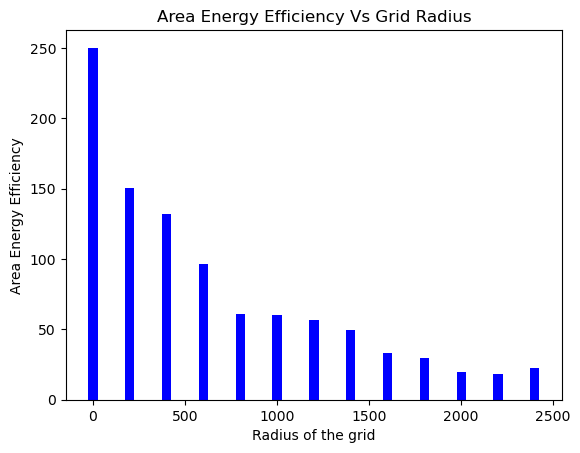

In [77]:
# Create a bar graph
bar_width = 50
plt.bar(grid_radius_array, area_energy_efficiency_3, color='blue', alpha=1, width=bar_width)
plt.ylabel('Area Energy Efficiency')
plt.xlabel('Radius of the grid')
plt.title('Area Energy Efficiency Vs Grid Radius')
plt.show()

# SINGLE IRS CASE (PRACTICAL, DISCRETE with B=3)

In [78]:
B = 3

quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

area_energy_efficiency_4 = []
area_spectral_efficiency_4 = []

for i in range(len(grid_radius_array)):

    grid_area = grid_area_list[i]
    
    # Generate IRS position_1
    # IRS_position_1 = IRS_POSITION_1_list[i]
    # xs_1, ys_1, zs_1 = IRS_POSITION_1

    # irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
    # loc_S_1 = irs_coords_1
    # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
    # print()

    loc_U = loc_U_list[i]
    
    # dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    # dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
    
    # Reshapiing the distance from antennas/BS to user
    dTU = dTU_list[i]
    # dTU = dTU.reshape(Nt,K)

    # Compute row-wise averages
    dSU_1 = dSU_1_list[i]
    # dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
    dSU_1 = dSU_1.reshape(1,K)

    # Compute the sum of elements in each row
    dTS_1 = dTS_1_list[i]
    # dTS_1 = np.mean(dTS_1, axis=1)
    # Compute the average of row sums
    dTS_1 = np.mean(dTS_1)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
    # Direct Link
    h_dk_values = h_dk_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, 1)

    # BS to IRS
    G1_ns_values = G1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)

    # IRS to Users
    h_rk1_ns_values = h_rk1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk1_h_ns_values = h_rk1_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Initialize list to store area_energy_efficiency
    area_energy_efficiency = []
    
    # Initialize area_spectral_efficiency for this case
    area_spectral_efficiency = []

    # Perform simulations
    for s in range(NUM_SIMULATIONS):
        h_dk = h_dk_values[s]
        h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
        h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
        G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
        
        theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )
        results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)

    # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
        arr_link_budget = np.zeros((K,1))
        for m in range(K):
            arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* (((h_dk[m])/(np.sqrt((dTU[m])**ALPHA)))+((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1))))))
            arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
            arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
            arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
            outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
        arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

        # Calculate the Area Spectral Efficiency (ASE)
        ASE = arr_sumrate_disc[s]/grid_area
        area_spectral_efficiency.append(ASE)

        # Calculate the total power of the system
        power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
        power_2 = compute_power_consumption_at_ris(B, Ns)
        power_3 = (10**(Pu/10))/1000
        power_3 = power_3 * K
        P = power_1 + power_2 + power_3

        # Compute the energy efficiency and the Area Energy Efficiency (AEE)
        ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
        AEE = ASE/P # Using the ASE and total power
        area_energy_efficiency.append(ee/1e6) 

    # Compute the average area energy efficiency
    area_energy_efficiency_4.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
    
    # Append the average ASE for this T to the list
    area_spectral_efficiency_4.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))
    
print('done')
print(area_energy_efficiency_4)

C:\Users\TQUma\AppData\Local\Temp\ipykernel_12796\777721866.py:87: RuntimeWarning: divide by zero encountered in divide
  ASE = arr_sumrate_disc[s]/grid_area


done
[341.37390273744256, 197.87608947582328, 170.84976139838392, 119.87350845096347, 70.0610921368605, 69.42011835718995, 63.47304653592811, 55.085049135057105, 32.81889819803696, 27.85615357036003, 18.534638810816638, 15.863617915421337, 22.313886361063407]


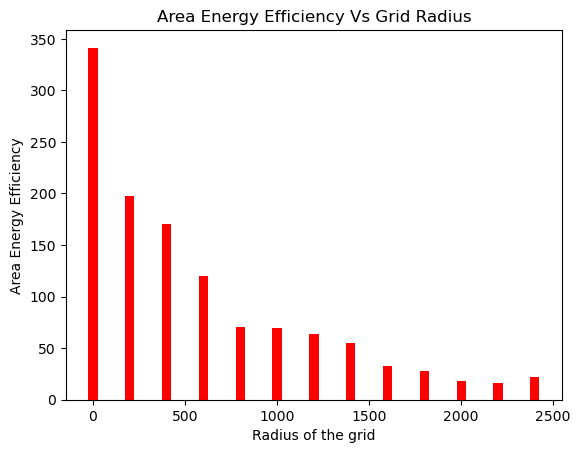

In [79]:
# Create a bar graph
bar_width = 50
plt.bar(grid_radius_array, area_energy_efficiency_4, color='red', alpha=1, width=bar_width)
plt.ylabel('Area Energy Efficiency')
plt.xlabel('Radius of the grid')
plt.title('Area Energy Efficiency Vs Grid Radius')
plt.show()

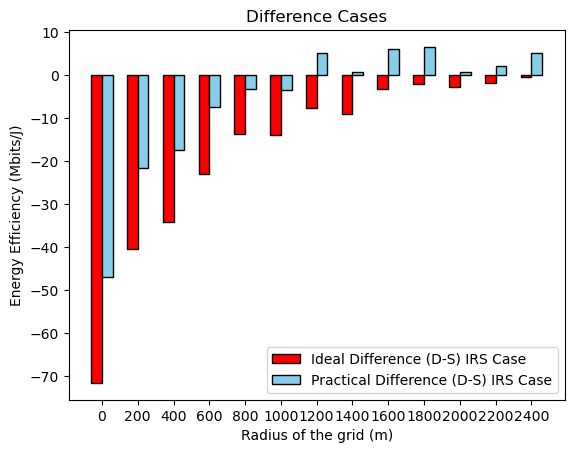

In [80]:
# Set width of bar
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(area_energy_efficiency_1))
r2 = [x + bar_width for x in r1]

result_1 = []
for i in range(len(area_energy_efficiency_1)):
    result_1.append(area_energy_efficiency_1[i] - area_energy_efficiency_3[i])    

result_2 = []
for i in range(len(area_energy_efficiency_2)):
    result_2.append(area_energy_efficiency_2[i] - area_energy_efficiency_4[i])    

# Plotting the bar charts
plt.bar(r1, result_1, color='red', width=bar_width, edgecolor='black', label='Ideal Difference (D-S) IRS Case')
plt.bar(r2, result_2, color='skyblue', width=bar_width, edgecolor='black', label='Practical Difference (D-S) IRS Case')

# Adding labels and ticks
plt.xlabel('Radius of the grid (m)')
plt.ylabel('Energy Efficiency (Mbits/J)')
plt.title('Difference Cases')
plt.xticks([r + bar_width / 2 for r in range(len(area_energy_efficiency_1))], grid_radius_array)
plt.legend()
plt.show()

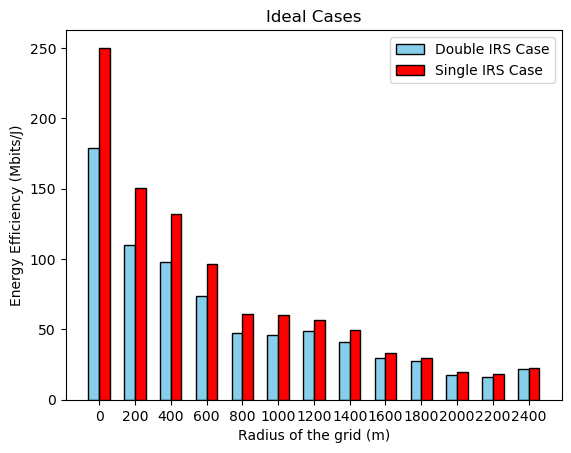

In [81]:
# Set width of bar
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(area_energy_efficiency_2))
r2 = [x + bar_width for x in r1]

# Plotting the bar charts
plt.bar(r1, area_energy_efficiency_1, color='skyblue', width=bar_width, edgecolor='black', label='Double IRS Case')
plt.bar(r2, area_energy_efficiency_3, color='red', width=bar_width, edgecolor='black', label='Single IRS Case')

# Adding labels and ticks
plt.xlabel('Radius of the grid (m)')
plt.ylabel('Energy Efficiency (Mbits/J)')
plt.title('Ideal Cases')
plt.xticks([r + bar_width / 2 for r in range(len(area_energy_efficiency_1))], grid_radius_array)
plt.legend()
plt.show()

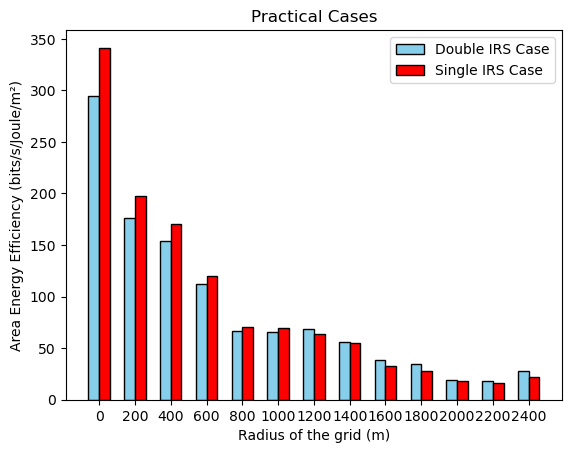

In [82]:
# Set width of bar
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(area_energy_efficiency_2))
r2 = [x + bar_width for x in r1]

# Plotting the bar charts
plt.bar(r1, area_energy_efficiency_2, color='skyblue', width=bar_width, edgecolor='black', label='Double IRS Case')
plt.bar(r2, area_energy_efficiency_4, color='red', width=bar_width, edgecolor='black', label='Single IRS Case')

# Adding labels and ticks
plt.xlabel('Radius of the grid (m)')
plt.ylabel('Area Energy Efficiency (bits/s/Joule/m²)')
plt.title('Practical Cases')
plt.xticks([r + bar_width / 2 for r in range(len(area_energy_efficiency_2))], grid_radius_array)
plt.legend()
plt.show()

In [83]:
r1T = np.transpose(np.reshape((r1), (1,len(r1))))
r2T = np.transpose(np.reshape((r2), (1,len(r2))))
result_1T = np.transpose(np.reshape(result_1, (1,len(result_1))))
result_2T = np.transpose(np.reshape(result_2, (1,len(result_2))))

area_energy_efficiency_1T = np.transpose(np.reshape(area_energy_efficiency_1, (1,len(area_energy_efficiency_1)))) # Double Ideal
area_energy_efficiency_2T = np.transpose(np.reshape(area_energy_efficiency_2, (1,len(area_energy_efficiency_2)))) # Double Practical
area_energy_efficiency_3T = np.transpose(np.reshape(area_energy_efficiency_3, (1,len(area_energy_efficiency_3)))) # Single Ideal
area_energy_efficiency_4T = np.transpose(np.reshape(area_energy_efficiency_4, (1,len(area_energy_efficiency_4)))) # Single Practical

print('r1T', r1T.shape)
print('r2T', r2T.shape)
print('result_1T', result_1T.shape)
print('result_2T', result_2T.shape)
print('area_energy_efficiency_1T', area_energy_efficiency_1T.shape)
print('area_energy_efficiency_2T', area_energy_efficiency_2T.shape)
print('area_energy_efficiency_3T', area_energy_efficiency_3T.shape)
print('area_energy_efficiency_4T', area_energy_efficiency_4T.shape)


# Stack the arrays horizontally
stacked_array = np.hstack((r1T, r2T, result_1T,result_2T, area_energy_efficiency_1T, area_energy_efficiency_2T, area_energy_efficiency_3T, area_energy_efficiency_4T))
stacked_array = np.array(stacked_array)

print('stacked_array', stacked_array.shape)

# Define the file path
file_path = './CSVDataFiles/BarDiffernce.csv'

# Define row headings
headings = ['r1', 'r2', 'IdealDifference', 'PracticalDifference', 'DoubleIdeal', 'DoublePractical', 'SingleIdeal', 'SinglePractical']

# Save the transposed array to a CSV file with row headings
np.savetxt(file_path, stacked_array, delimiter=',', header=','.join(headings), comments='')

r1T (13, 1)
r2T (13, 1)
result_1T (13, 1)
result_2T (13, 1)
area_energy_efficiency_1T (13, 1)
area_energy_efficiency_2T (13, 1)
area_energy_efficiency_3T (13, 1)
area_energy_efficiency_4T (13, 1)
stacked_array (13, 8)
